In [1]:
import sys
import matplotlib.pyplot as plt  # type: ignore
import seaborn as sns  # type: ignore
import numpy as np  # type: ignore
import matplotlib.colors as mcolors  # type: ignore

sys.path.append("../")
from opt.data_process import DataProcessor
import contextily as ctx
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib import rc

# set arial as the default font
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc("font", **{"family": "sans-serif", "sans-serif": ["Arial"]})

In [2]:
data_processor = DataProcessor()
#set demographic partition based on quantiles
kwargs = {
    "income_bins": 4,
    "mud_bins": 4,
    "employment_bins": 4,
}
# three dfs respectively: demographic data, commute matrix, and VKT flow matrix
df1, df2, df3 = data_processor.process_demo_data(**kwargs)

# set crs to 3857 (from spherical to flat)
df1.crs = "EPSG:4326"
df1 = df1.to_crs("EPSG:3857")

In [3]:
df1.head()

,tract_id,popu,employed_popu,income,perc_multi_unit_dwellings,income_level,mud_level,employment_level,major_ethnicity,char_num_home,char_capacity_home,char_capacity_not_home,char_num_not_home,veh_num,pub_char_num,disadvantaged,geometry,work_popu_LODES,employed_popu_LODES,work_popu_processed
0,6001400100,3269,2648.0,234236.0,0.534759,Q4,Q1,Q2,White,969,969,13,1,2998.0,1.0,False,"POLYGON ((-13608463.772 4563242.955, -13607913...",496,764,1719
1,6001400200,2147,1836.0,225500.0,34.720701,Q4,Q2,Q3,White,678,678,0,0,2218.0,0.0,False,"POLYGON ((-13609633.517 4557284.19, -13609498....",878,568,2838
2,6001400300,5619,4826.0,164000.0,54.822869,Q4,Q3,Q3,White,2108,2108,200,2,7229.0,1.0,False,"POLYGON ((-13610515.39 4556630.836, -13610431....",2024,1682,5807
3,6001400400,4278,3364.0,158836.0,46.075949,Q4,Q2,Q1,White,1373,1373,0,0,4612.0,0.0,False,"POLYGON ((-13610121.876 4557100.091, -13610065...",822,1144,2417
4,6001400500,3949,3470.0,95078.0,47.472527,Q2,Q3,Q3,White,1138,1138,0,0,4433.0,0.0,False,"POLYGON ((-13610968.349 4557990.592, -13610918...",348,1151,1049


# Resource and Demographics Distributions

In [4]:
print("Total population in Oakland:", df1.popu.sum())
print("Total employed population in Oakland:", df1.employed_popu.sum())
print("Pct captured by LODES 2021: ", 300253/df1.employed_popu.sum())
print("Num of public chargers in Oak:", df1.char_num_not_home.sum())
print("Num of residential chargers in Oak:", df1.char_num_home.sum())
print("Pct of home chargers in Oak:", df1.char_num_home.sum()/(df1.char_num_not_home.sum()+df1.char_num_home.sum()))
print("Pct of home charger capacity in Oak:", df1.char_capacity_home.sum()/(df1.char_capacity_not_home.sum()+df1.char_capacity_home.sum()))


print("Capacity of public chargers in Oak:", df1.char_capacity_not_home.sum())
print("Capacity of residential chargers in Oak:", df1.char_capacity_home.sum())
print("Total capacity in Oak:", df1.char_capacity_home.sum() + df1.char_capacity_not_home.sum())
print("Pct of home charger capacity in Oak:", df1.char_capacity_home.sum()/(df1.char_capacity_not_home.sum()+df1.char_capacity_home.sum()))

Total population in Oakland: 447531
Total employed population in Oakland: 369985.0
Pct captured by LODES 2021:  0.8115274943578794
Num of public chargers in Oak: 663
Num of residential chargers in Oak: 111008
Pct of home chargers in Oak: 0.9940629169614313
Pct of home charger capacity in Oak: 0.805000797691047
Capacity of public chargers in Oak: 26890
Capacity of residential chargers in Oak: 111008
Total capacity in Oak: 137898
Pct of home charger capacity in Oak: 0.805000797691047


In [5]:
df1["car_ownership_rate"] = df1["veh_num"]/df1["popu"]
df1["total_char_num"] = df1["char_num_not_home"] + df1["char_num_home"]
df1["total_char_capacity"] = df1["char_capacity_not_home"] + df1["char_capacity_home"]
df1["char_per_capita"] = df1["total_char_num"]/df1["popu"]
df1["char_per_veh"] = df1["total_char_num"]/df1["veh_num"]
df1["char_capacity_per_capita"] = df1["total_char_capacity"]/df1["popu"]
df1["char_capacity_per_car"] = df1["total_char_capacity"]/df1["veh_num"]

df1["VKT_flow_out_km"] = df3.sum(axis=1).values
df1["VKT_flow_in_km"] = df3.sum(axis=0).values

df1["char_capacity_per_VKT_out"] = df1["total_char_capacity"]/df1["VKT_flow_out_km"]
df1["char_capacity_per_VKT_in"] = df1["total_char_capacity"]/df1["VKT_flow_in_km"]

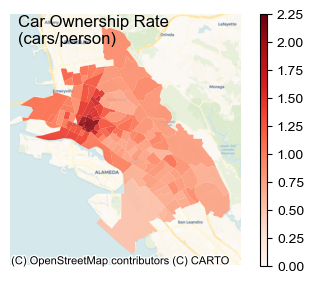

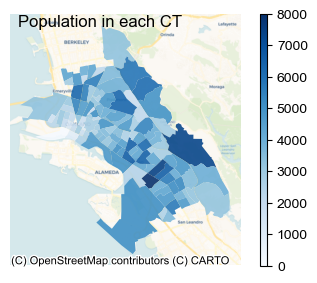

In [6]:
feature = "car_ownership_rate"
df = df1#[df1["pub_char_num"] > 0]
cmap="Reds"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax, vmin=0, vmax=2.25)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
# norm = mcolors.Normalize(vmin=0, vmax=2.25)
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# f.colorbar(sm, cax=cax)
plt.text(-35, 2.25, "Car Ownership Rate\n(cars/person)", fontsize=12, ha="left", va="top")
plt.savefig("CarOwnershipRate.pdf", dpi=300, bbox_inches="tight")


feature = "popu"
cmap="Blues"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=8000)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 8000, "Population in each CT", fontsize=12, ha = "left", va = "top")
plt.savefig("PopulationInCT.pdf", dpi=300, bbox_inches="tight")


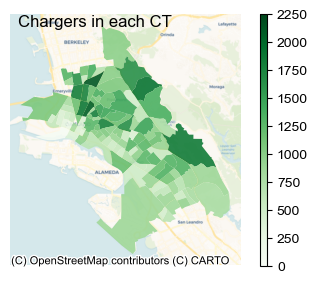

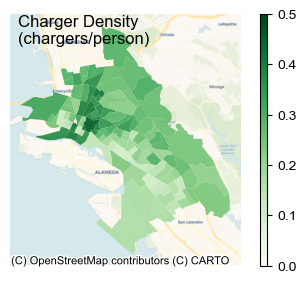

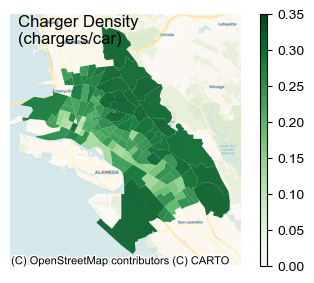

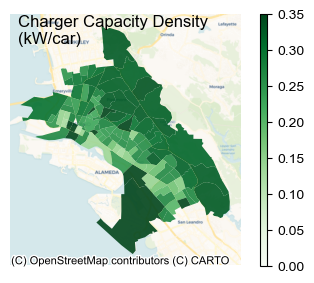

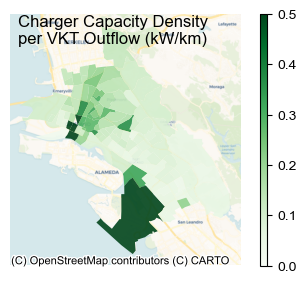

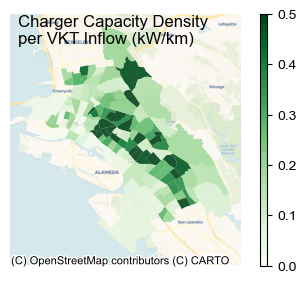

In [7]:
feature = "total_char_num"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=2250)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 2250, "Chargers in each CT", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerInCT.pdf", dpi=300, bbox_inches="tight")


feature = "char_per_capita"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax, vmin=0, vmax=0.5)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.5, "Charger Density\n(chargers/person)", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerperCapita.pdf", dpi=300, bbox_inches="tight")


feature = "char_per_veh"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=0.35)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.35, "Charger Density\n(chargers/car)", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerperCar.pdf", dpi=300, bbox_inches="tight")


feature = "char_capacity_per_car"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=0.35)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.35, "Charger Capacity Density\n(kW/car)", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerCapacityperCar.pdf", dpi=300, bbox_inches="tight")


feature = "char_capacity_per_VKT_out"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=0.5)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.5, "Charger Capacity Density\nper VKT Outflow (kW/km)", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerCapacityperVKTout.pdf", dpi=300, bbox_inches="tight")


feature = "char_capacity_per_VKT_in"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=0.5)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.5, "Charger Capacity Density\nper VKT Inflow (kW/km)", fontsize=12, ha = "left", va="top")

plt.savefig("ChargerCapacityperVKTin.pdf", dpi=300, bbox_inches="tight")

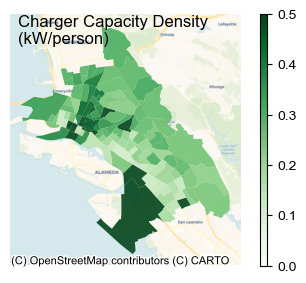

In [8]:
feature = "char_capacity_per_capita"
cmap="Greens"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax,vmin=0, vmax=0.5)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 0.5, "Charger Capacity Density\n(kW/person)", fontsize=12, ha = "left", va="top")
plt.savefig("ChargerCapacityperCapita.pdf", dpi=300, bbox_inches="tight")


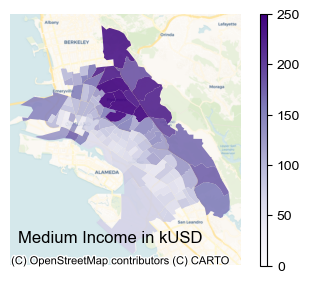

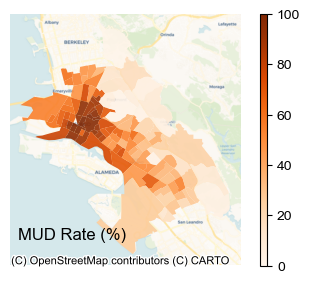

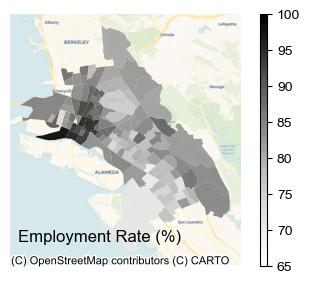

In [9]:
df["income_kusd"] = df["income"]/1000

feature = "income_kusd"
cmap="Purples"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax, vmin=0, vmax=250)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
# sm = plt.cm.ScalarMappable(cmap=cmap)
# # set ticks on colorbar
# f.colorbar(sm, cax=cax)
plt.text(-35, 35, "Medium Income in kUSD", fontsize=12, ha = "left", va="top")
plt.savefig("Income_kUSD.pdf", dpi=300, bbox_inches="tight")


feature = "perc_multi_unit_dwellings"
cmap="Oranges"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax, vmin=0, vmax=100)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 15, "MUD Rate (%)", fontsize=12, ha = "left", va="top")
plt.savefig("MUDRatePct.pdf", dpi=300, bbox_inches="tight")

df1["employed_rate"] = df1["employed_popu"] / df1["popu"] * 100

feature = "employed_rate"
cmap="Greys"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.2)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=0.9, legend=True, cax=cax, vmin=65, vmax=100)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
plt.text(-35, 70, "Employment Rate (%)", fontsize=12, ha = "left", va="top")
plt.savefig("EmployRatePct.pdf", dpi=300, bbox_inches="tight")

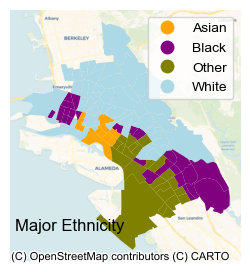

In [10]:

feature = "major_ethnicity"
cmap = mcolors.ListedColormap(["orange", "purple", "olive", "lightblue"])
# cmap = "Set3"

f, ax = plt.subplots(1, 1, figsize=(4, 3), sharex=True, sharey=True)
f.tight_layout(pad=0.8)
ax.set_axis_off()
divider = make_axes_locatable(ax)
ux = df.plot(feature, ax=ax, edgecolor="none", cmap=cmap, alpha=1, legend=True)
ctx.add_basemap(ux, source=ctx.providers.CartoDB.Voyager)
f.text(0.25, 0.25, "Major Ethnicity", fontsize=12, ha = "left", va="top")
plt.savefig("MajorEthnicity.pdf", dpi=300, bbox_inches="tight")

# OD Pair / Commuting Patterns

In [11]:
data_oak = df2.copy()
data_oak_temp = data_oak.sum(axis=0) # sum over all rows to get the total flow-in of each column (workplace)


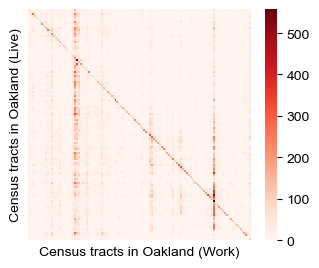

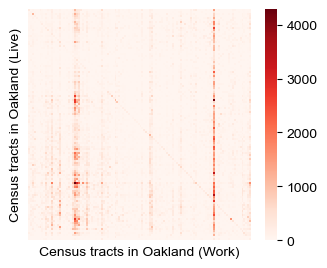

In [12]:
data_oak = df2.copy().values

fig, ax = plt.subplots(figsize=(3.6, 3))
sns.heatmap(data_oak, cmap="Reds", label="Num of chargers")
plt.xlabel("Census tracts in Oakland (Work)")
plt.ylabel("Census tracts in Oakland (Live)")
plt.xticks([])
plt.yticks([])
plt.savefig("ct_work_flow.pdf" , bbox_inches="tight", dpi=300)


data_oak_VKT = df3.copy().values

fig, ax = plt.subplots(figsize=(3.6, 3))
sns.heatmap(data_oak_VKT, cmap="Reds", label="VKT flow")
plt.xlabel("Census tracts in Oakland (Work)")
plt.ylabel("Census tracts in Oakland (Live)")
plt.xticks([])
plt.yticks([])
plt.savefig("ct_work_VKT_flow.pdf" , bbox_inches="tight", dpi=300)

# # set diag value to zero
# fig, ax = plt.subplots(figsize=(3.6, 3))
# data_oak[np.diag_indices_from(data_oak)] = 0
# sns.heatmap(data_oak, cmap="Reds", label="Num of chargers")
# plt.xlabel("Census tracts in Oakland (Work)")
# plt.ylabel("Census tracts in Oakland (Live)")
# plt.xticks([])
# plt.yticks([])
# plt.savefig("ct_work_flow_mute_dig.pdf" , bbox_inches="tight")

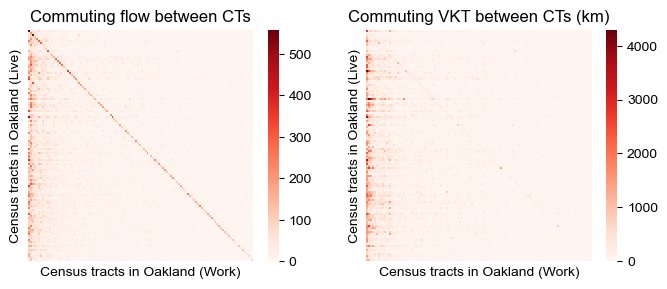

In [13]:
# reorder the matrix by the total flow-in of each column

data_oak = df2.copy()
data_oak_temp = data_oak.sum(axis=0) # sum over all rows to get the total flow-in of each column (workplace)
data_oak_temp = data_oak_temp.sort_values(ascending=False)
new_order = data_oak_temp.index
data_oak = data_oak.reindex(index=new_order, columns=new_order)

fig, ax = plt.subplots(1, 2, figsize=(8, 3))
sns.heatmap(data_oak, cmap="Reds", label="Num of chargers", ax=ax[0])
ax[0].set_xlabel("Census tracts in Oakland (Work)")
ax[0].set_ylabel("Census tracts in Oakland (Live)")
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title("Commuting flow between CTs", fontsize=12, ha = "center")

# plt.savefig("ct_work_flow_ordered.pdf" , bbox_inches="tight", dpi=300)

data_oak_VKT = df3.copy()
data_oak_VKT = data_oak_VKT.reindex(index=new_order, columns=new_order)

# fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(data_oak_VKT, cmap="Reds", label="VKT flow", ax=ax[1])
ax[1].set_xlabel("Census tracts in Oakland (Work)")
ax[1].set_ylabel("Census tracts in Oakland (Live)")
ax[1].set_xticks([])
ax[1].set_yticks([])
# move title slightly to the right
ax[1].set_title("Commuting VKT between CTs (km)", fontsize=12, ha = "center")
# annotate in the plot
# plt.annotate("1", (0, 0), fontsize=6, color="black")
plt.savefig("ct_work_and_VKT_flow_ordered.pdf" , bbox_inches="tight", dpi=300)


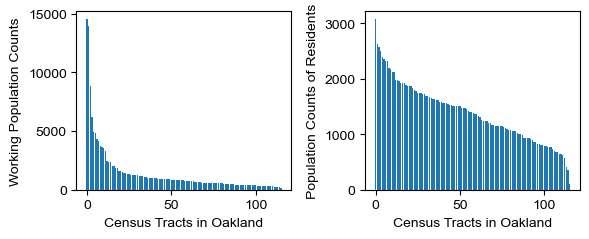

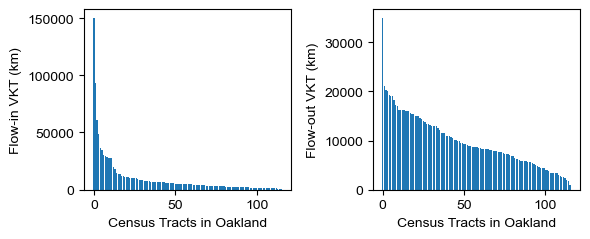

In [14]:
work_popu_oak = df2.sum(axis=0)
live_popu_oak = df2.sum(axis=1)
work_VKT_oak = df3.sum(axis=0)
live_VKT_oak = df3.sum(axis=1)

fig, ax = plt.subplots(1,2, figsize = (6,2.5), dpi = 100, tight_layout = True)
ax[0].bar(np.arange(len(work_popu_oak)), work_popu_oak.sort_values(ascending=False), label="Working population in oakland (Descending)")
ax[1].bar(np.arange(len(live_popu_oak)), live_popu_oak.sort_values(ascending=False), label="Population in oakland (Descending)")
ax[0].set_xlabel("Census Tracts in Oakland")
ax[0].set_ylabel("Working Population Counts")
ax[1].set_xlabel("Census Tracts in Oakland")
ax[1].set_ylabel("Population Counts of Residents")

plt.savefig("live_work_distribution_sorted.pdf", dpi = 300)

fig, ax = plt.subplots(1,2, figsize = (6,2.5), dpi = 100, tight_layout = True)
ax[0].bar(np.arange(len(work_VKT_oak)), work_VKT_oak.sort_values(ascending=False), label="VKT flow in oakland (Descending)")
ax[1].bar(np.arange(len(live_VKT_oak)), live_VKT_oak.sort_values(ascending=False), label="VKT flow in oakland (Descending)")
ax[0].set_xlabel("Census Tracts in Oakland")
ax[0].set_ylabel("Flow-in VKT (km)")
ax[1].set_xlabel("Census Tracts in Oakland")
ax[1].set_ylabel("Flow-out VKT (km)")


plt.savefig("live_work_vkt_distribution_sorted.pdf", dpi = 300)


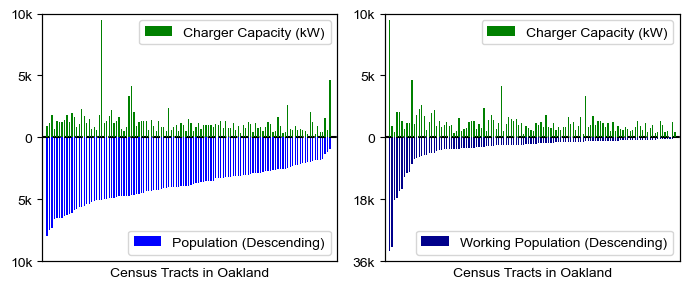

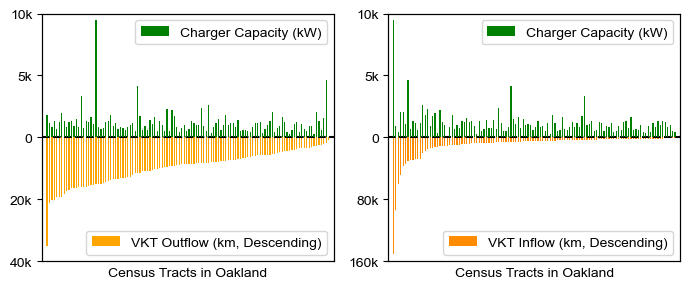

In [15]:
fig, ax = plt.subplots(1,2, figsize = (7,3), dpi = 100, tight_layout = True)
ax = ax.flatten()
df_sorted = df.sort_values(by="popu", ascending=False)
df_sorted["popu"].plot(kind="bar", ax=ax[0], label="Population (Descending)", color = "blue")
ax0 = ax[0].twinx()
df_sorted["total_char_capacity"].plot(kind="bar", ax=ax0, label="Charger Capacity (kW)", color = "green")
# horizontal line
ax[0].axhline(y=0, color='k', linestyle='--')
ax[0].legend(loc="lower right")
ax0.legend(loc="upper right")
# y_axis to be positive in the plot
ax[0].invert_yaxis()
ax[0].set_yticks([10000, 5000, 0, -5000, -10000], ["10k", "5k", "0", "5k", "10k"])
ax0.set_yticks([10000, 5000, 0, -5000, -10000])
ax0.set_yticks([])
ax[0].set_xlim([-2, 117])
ax[0].set_xticks([])


df_sorted1 = df_sorted.sort_values(by="work_popu_processed", ascending=False)
df_sorted1["work_popu_processed"].plot(kind="bar", ax=ax[1], label="Working Population (Descending)", color = "darkblue")
ax[1].axhline(y=0, color='k', linestyle='--')
ax1 = ax[1].twinx()
df_sorted1["total_char_capacity"].plot(kind="bar", ax=ax1, label="Charger Capacity (kW)", color = "green")
ax[1].legend(loc="lower right")
ax1.legend(loc="upper right")
# y_axis to be positive in the plot
ax[1].invert_yaxis()
ax[1].set_yticks([36000, 18000, 0, -18000, -36000], ["36k", "18k", "0", "5k", "10k"])
ax1.set_yticks([10000, 5000, 0, -5000, -10000])
ax[1].set_xlim([-2, 117])
ax[1].set_xticks([])
ax1.set_yticks([])

ax[0].set_xlabel("Census Tracts in Oakland")
ax[1].set_xlabel("Census Tracts in Oakland")

plt.savefig("popu_workpopu_charger_capacity_sorted.pdf", dpi = 300)


fig, ax = plt.subplots(1,2, figsize = (7,3), dpi = 100, tight_layout = True)

df_sorted2 = df_sorted.sort_values(by="VKT_flow_out_km", ascending=False)
df_sorted2["VKT_flow_out_km"].plot(kind="bar", ax=ax[0], label="VKT Outflow (km, Descending)", color = "orange")
ax[0].axhline(y=0, color='k', linestyle='--')
ax2 = ax[0].twinx()
df_sorted2["total_char_capacity"].plot(kind="bar", ax=ax2, label="Charger Capacity (kW)", color = "green")
ax[0].legend(loc="lower right")
ax2.legend(loc="upper right")
# y_axis to be positive in the plot
ax[0].invert_yaxis()
ax[0].set_yticks([40000, 20000, 0, -20000, -40000], ["40k", "20k", "0", "5k", "10k"])
ax2.set_yticks([10000, 5000, 0, -5000, -10000])
ax[0].set_xlim([-2, 117])
ax[0].set_xticks([])
ax2.set_yticks([])

df_sorted3 = df_sorted.sort_values(by="VKT_flow_in_km", ascending=False)
df_sorted3["VKT_flow_in_km"].plot(kind="bar", ax=ax[1], label="VKT Inflow (km, Descending)", color = "darkorange")
ax[1].axhline(y=0, color='k', linestyle='--')
ax3 = ax[1].twinx()
df_sorted3["total_char_capacity"].plot(kind="bar", ax=ax3, label="Charger Capacity (kW)", color = "green")
ax[1].legend(loc="lower right")
ax3.legend(loc="upper right")
# y_axis to be positive in the plot
ax[1].invert_yaxis()
ax[1].set_yticks([160000, 80000, 0, -80000, -160000], ["160k", "80k", "0", "5k", "10k"])
ax3.set_yticks([10000, 5000, 0, -5000, -10000])
ax[1].set_xlim([-2, 117])
ax[1].set_xticks([])
ax3.set_yticks([])


ax[0].set_xlabel("Census Tracts in Oakland")
ax[1].set_xlabel("Census Tracts in Oakland")

plt.savefig("VKT_flow_in_out_charger_capacity_sorted.pdf", dpi = 300)

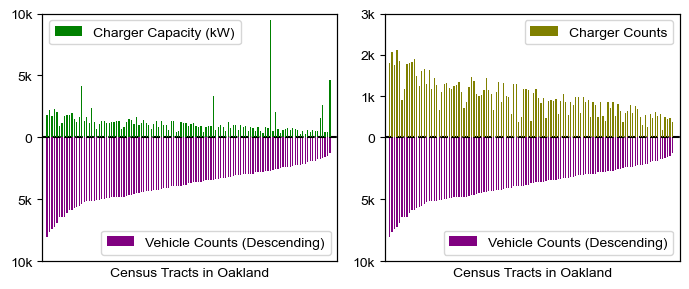

In [16]:
fig, ax = plt.subplots(1, 2, figsize = (7, 3), dpi = 100, tight_layout = True)
df_sorted4 = df_sorted.sort_values(by="veh_num", ascending=False)
df_sorted4["veh_num"].plot(kind="bar", label="Vehicle Counts (Descending)", color = "purple", ax=ax[0])
ax0 = ax[0].twinx()
df_sorted4["total_char_capacity"].plot(kind="bar", ax=ax0, label="Charger Capacity (kW)", color = "green")
# horizontal line
ax[0].axhline(y=0, color='k', linestyle='--')
ax[0].legend(loc="lower right")
ax0.legend(loc="upper left")
# y_axis to be positive in the plot
ax[0].invert_yaxis()
ax[0].set_yticks([10000, 5000, 0, -5000, -10000], ["10k", "5k", "0", "5k", "10k"])
ax0.set_yticks([10000, 5000, 0, -5000, -10000])
ax0.set_yticks([])
ax[0].set_xlim([-2, 117])
ax[0].set_xticks([])
ax[0].set_xlabel("Census Tracts in Oakland")

df_sorted4["veh_num"].plot(kind="bar", label="Vehicle Counts (Descending)", color = "purple", ax=ax[1])
ax1 = ax[1].twinx()
df_sorted4["total_char_num"].plot(kind="bar", ax=ax1, label = "Charger Counts", color = "olive")
ax[1].axhline(y=0, color='k', linestyle='--')
ax[1].legend(loc="lower right")
ax1.legend(loc="upper right")
# y_axis to be positive in the plot
ax[1].invert_yaxis()
ax[1].set_yticks([10000, 5000, 0, -10000/3, -20000/3, -10000], ["10k", "5k", "0", "1k", "2k", "3k"])
ax1.set_yticks([3000, 2000, 1000, 0, -1000, -2000, -3000])
ax1.set_yticks([])
ax[1].set_xlim([-2, 117])
ax[1].set_xticks([])
ax[1].set_xlabel("Census Tracts in Oakland")

plt.savefig("veh_num_charger_capacity_sorted.pdf", dpi = 300)

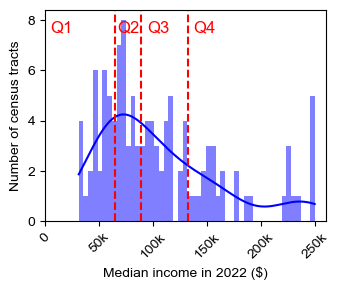

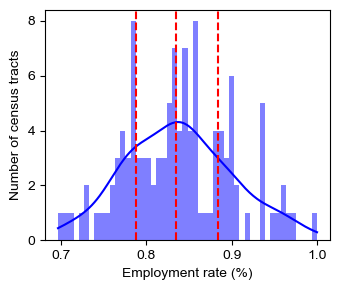

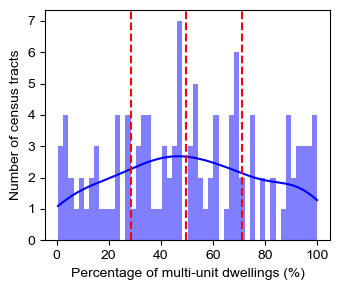

In [17]:
fig, ax = plt.subplots(figsize=(3.5, 3))
sns.histplot(df1, x="income", bins=50, ax=ax, kde=True, color="b", edgecolor=None)
plt.xlabel("Median income in 2022 ($)")
plt.ylabel("Number of census tracts")
# plot quantiles partition
quantiles = df1["income"].quantile([0.25, 0.5, 0.75])
for quantile in quantiles:
    plt.axvline(quantile, color="r", linestyle="--")

plt.xticks(np.arange(0, 260000, 50000), ["0", "50k", "100k", "150k", "200k", "250k"])
# Notation Q1-4
buffer = 5000
plt.text(0 +buffer, 7.5, "Q1", fontsize=12, color="r")
plt.text(quantiles[0.25]+buffer*0.5, 7.5, "Q2", fontsize=12, color="r")
plt.text(quantiles[0.5]+buffer, 7.5, "Q3", fontsize=12, color="r")
plt.text(quantiles[0.75]+buffer, 7.5, "Q4", fontsize=12, color="r")
# rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("income_hist_q4.png", dpi = 300)

df1["employment_rate"] = df1["employed_popu"] / df1["popu"]
fig, ax = plt.subplots(figsize=(3.5, 3))
sns.histplot(df1, x="employment_rate", bins=50, ax=ax, kde=True, color="b", edgecolor=None)
quantiles = df1["employment_rate"].quantile([0.25, 0.5, 0.75])
for quantile in quantiles:
    plt.axvline(quantile, color="r", linestyle="--")
plt.xlabel("Employment rate (%)")
plt.ylabel("Number of census tracts")
plt.tight_layout()

plt.savefig("employment_rate_hist_q4.png", dpi = 300)


fig, ax = plt.subplots(figsize=(3.5, 3))
sns.histplot(df1, x="perc_multi_unit_dwellings", bins=50, ax=ax, kde=True, color="b", edgecolor=None)
quantiles = df1["perc_multi_unit_dwellings"].quantile([0.25, 0.5, 0.75])
for quantile in quantiles:
    plt.axvline(quantile, color="r", linestyle="--")
plt.xlabel("Percentage of multi-unit dwellings (%)")
plt.ylabel("Number of census tracts")
plt.tight_layout()

plt.savefig("perc_multi_unit_dwellings_hist_q4.png", dpi = 300)